# Powerlifting Data Science Project: Analysis Notebook

## Imports and Setup

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import statsmodels.stats.oneway as sm_ow

## 1. Introduction

Powerlifting is a strength sport in which competitors attempt to lift the maximum possible weight in three standardized movements across: the squat, bench press, and deadlift, in multiple attempts. Performance is evaluated by the total (TotalKg) sum of the maximum weight completed for each of the three lifts. Powerlifters compete in weight classes, with their rankings being evaluated based on the performance of other competitors of the same weight class.

A classic metric for measuring powerlifting performance directly between weight classes is the Wilks score, using a function that takes a competitors Total and bodyweight as inputs, and outputs their Wilks score.

The Wilks score is computed as:

$$
\text{Wilks} = \frac{W}{a + b\,x + c\,x^2 + d\,x^3 + e\,x^4 + f\,x^5}
$$

where:

- \(W\) is the total weight lifted (kg),
- \(x\) is the lifter's bodyweight (kg),
- \(a, b, c, d, e, f\) are sex-specific Wilks coefficients.

Despite widespread use of Wilks scores in competition, important questions remain about how performance differs across sexes, weight classes, and individual lifts, and how strongly bodyweight influences performance outcomes. Understanding these relationships provides insight into competitive fairness, performance scaling, and the limitations of bodyweight-adjusted metrics.

This notebook uses data from the Open Powerlifting Database to explore performance patterns among adult raw competitors. Using a combination of descriptive statistics, hypothesis testing, correlation analysis, and linear regression, the analysis addresses four key questions:
1. Whether Wilks scores differ between male and female competitors
2. Whether total weight lifted differs across bodyweight classes
3. How strongly bodyweight is associated with performance in each competition lift
4. How lift performance changes, on average, with increasing bodyweight

Together, these analyses provide a data-driven view of how bodyweight relates to strength performance in competitive powerlifting.

---

Dataset source (Kaggle): https://www.kaggle.com/datasets/open-powerlifting/powerlifting-database/data

## 2. Data Cleaning and Preprocessing

The raw Open Powerlifting dataset is loaded from `archive/openpowerlifting.csv`.

In [6]:
ARCHIVE_PATH = "archive/openpowerlifting.csv"

df_raw = pd.read_csv(ARCHIVE_PATH, low_memory=False)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1423354 entries, 0 to 1423353
Data columns (total 37 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Name             1423354 non-null  object 
 1   Sex              1423354 non-null  object 
 2   Event            1423354 non-null  object 
 3   Equipment        1423354 non-null  object 
 4   Age              757527 non-null   float64
 5   AgeClass         786800 non-null   object 
 6   Division         1415176 non-null  object 
 7   BodyweightKg     1406622 non-null  float64
 8   WeightClassKg    1410042 non-null  object 
 9   Squat1Kg         337580 non-null   float64
 10  Squat2Kg         333349 non-null   float64
 11  Squat3Kg         323842 non-null   float64
 12  Squat4Kg         3696 non-null     float64
 13  Best3SquatKg     1031450 non-null  float64
 14  Bench1Kg         499779 non-null   float64
 15  Bench2Kg         493486 non-null   float64
 16  Bench3Kg         4

An analysis-ready dataset was created from the original Open Powerlifting Database using the following steps:

- Because official powerlifting results are determined by the best successful attempt for each lift, individual attempt-level variables (e.g., first attempts) are not required for this analysis and were removed.
- Restricted the dataset to **raw (unequipped) powerlifting performances** to reduce inconsistencies introduced by supportive equipment
- Removed records with missing values in key fields used for analysis
- Excluded observations containing implausible values (e.g., BodyweightKg ≤ 0 or TotalKg ≤ 0)
- Filtered to adult competitors (Age ≥ 18 when age information was available)

For this analysis, we restrict the dataset to adult powerlifters competing in standard open weight classes. Bodyweights below 40 kg were excluded because they fall outside typical adult competitive categories and are likely to represent youth or non-comparable populations.

Bodyweight and lift values in the Open Powerlifting Database are standardized and reported in kilograms (kg).

The resulting cleaned dataset was saved as `data/openpowerlifting_cleaned.csv` and used for all subsequent statistical analyses.

In [7]:
os.makedirs("data", exist_ok=True)

keep_cols = [
    "Sex","Equipment","Wilks","WeightClassKg","TotalKg","BodyweightKg",
    "Best3SquatKg","Best3BenchKg","Best3DeadliftKg","Age",
]

df = df_raw.loc[:, keep_cols].copy()

# Filters
df = df[df["Equipment"] == "Raw"]
df = df[df["Age"].isna() | (df["Age"] >= 18)]  # matches your original behavior


# Drop missing required values
required = ["Sex","Wilks","WeightClassKg","TotalKg","BodyweightKg",
            "Best3SquatKg","Best3BenchKg","Best3DeadliftKg"]
df = df.dropna(subset=required)

# Remove implausible or irrelevant values
df = df[(df["BodyweightKg"] > 0) & (df["TotalKg"] > 0)]
df = df[(df["Best3SquatKg"] > 0) & (df["Best3BenchKg"] > 0) & (df["Best3DeadliftKg"] > 0)]
df = df[df["BodyweightKg"] >= 40]


# Only 'Raw' category counts
df = df.drop(columns=["Equipment"])

CLEAN_PATH = "data/openpowerlifting_cleaned.csv"
df.to_csv(CLEAN_PATH, index=False)

summary_stats = df[["TotalKg", "BodyweightKg"]].agg(["min", "max"])
summary_stats




,TotalKg,BodyweightKg
min,60.0,40.0
max,1112.5,233.0


Totals greater than zero were retained, as low totals can reflect valid competition performances among novice or lightweight competitors.

In addition, records with missing age were also retained, provided there was no evidence that the competitor was under 18 and minimum bodyweight standards as mentioned above were met.

In [13]:
df_clean = pd.read_csv(CLEAN_PATH)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248109 entries, 0 to 248108
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Sex              248109 non-null  object 
 1   Wilks            248109 non-null  float64
 2   WeightClassKg    248109 non-null  object 
 3   TotalKg          248109 non-null  float64
 4   BodyweightKg     248109 non-null  float64
 5   Best3SquatKg     248109 non-null  float64
 6   Best3BenchKg     248109 non-null  float64
 7   Best3DeadliftKg  248109 non-null  float64
 8   Age              188072 non-null  float64
dtypes: float64(7), object(2)
memory usage: 17.0+ MB


## 3. Exploratory Data Analysis (EDA)

Exploratory visualizations is conducted to evaluate data completeness and summarize key numerical variables before proceeding to statistical testing.

These descriptive plots are intended to provide context for subsequent analyses.


In [14]:
eda_cols = [
    "Sex", "Equipment", "Age", "BodyweightKg", "WeightClassKg",
    "Best3SquatKg", "Best3BenchKg", "Best3DeadliftKg",
    "TotalKg", "Wilks"
]

df_raw[eda_cols].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1423354 entries, 0 to 1423353
Data columns (total 10 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Sex              1423354 non-null  object 
 1   Equipment        1423354 non-null  object 
 2   Age              757527 non-null   float64
 3   BodyweightKg     1406622 non-null  float64
 4   WeightClassKg    1410042 non-null  object 
 5   Best3SquatKg     1031450 non-null  float64
 6   Best3BenchKg     1276181 non-null  float64
 7   Best3DeadliftKg  1081808 non-null  float64
 8   TotalKg          1313184 non-null  float64
 9   Wilks            1304407 non-null  float64
dtypes: float64(7), object(3)
memory usage: 108.6+ MB


Several variables (e.g., Age and attempt-level lift data) contain substantial missing values and were treated accordingly during preprocessing.


### Descriptive Statistics

In [15]:
total_stats = df["TotalKg"].agg(
    Mean="mean",
    Median="median",
    Q1=lambda x: x.quantile(0.25),
    Q3=lambda x: x.quantile(0.75),
    Min="min",
    Max="max"
)

total_stats["IQR"] = total_stats["Q3"] - total_stats["Q1"]
total_stats


Mean       466.136628
Median     475.000000
Q1         330.000000
Q3         580.000000
Min         60.000000
Max       1112.500000
IQR        250.000000
Name: TotalKg, dtype: float64

Descriptive statistics show a wide performance range, with a median total of 475 kg and an interquartile range of 250 kg, indicating substantial variability across competitors.


### Distribution of Total Weight Lifted
A histogram of total weight lifted is used to summarize the overall distribution of performance levels across competitors.


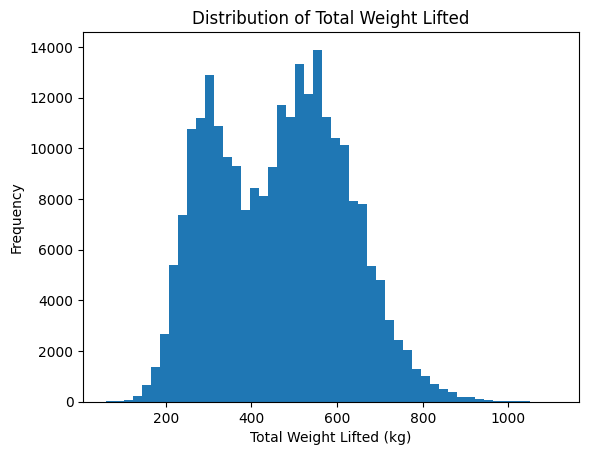

In [16]:
plt.figure()
plt.hist(df_clean["TotalKg"], bins=50)
plt.xlabel("Total Weight Lifted (kg)")
plt.ylabel("Frequency")
plt.title("Distribution of Total Weight Lifted")
plt.show()

#### Intepretation

The distribution of total weight lifted is right-skewed, with most observations concentrated in the midrange and a long tail toward very high totals. This pattern suggests heterogeneity across lifters and motivates examining distributions stratified by sex in subsequent analysis.

### Bodyweight and Total Performance

A scatter plot is used to explore the relationship between competitor bodyweight and total weight lifted.

This plot reflects the cleaned analysis dataset after applying all preprocessing filters described above (including the adult bodyweight threshold).

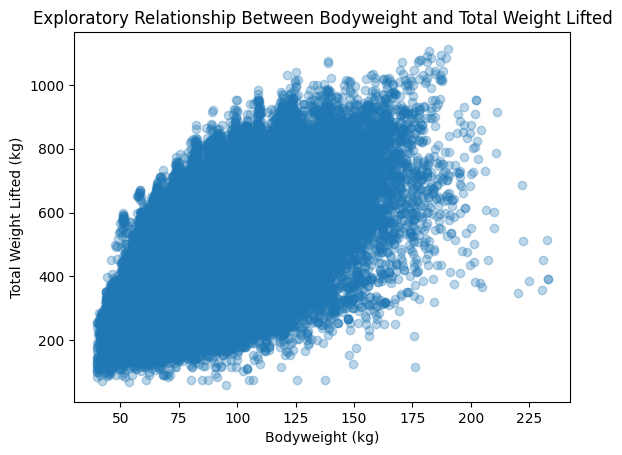

In [17]:
mask = df_clean["BodyweightKg"] >= 40

plt.figure()
plt.scatter(
    df_clean.loc[mask, "BodyweightKg"],
    df_clean.loc[mask, "TotalKg"],
    alpha=0.3
)
plt.xlabel("Bodyweight (kg)")
plt.ylabel("Total Weight Lifted (kg)")
plt.title("Exploratory Relationship Between Bodyweight and Total Weight Lifted")
plt.show()


#### Interpretation

The scatterplot shows a clear positive and approximately linear relationship between bodyweight and total weight lifted, with variability increasing at higher bodyweights

#### Wilks Scores by Sex

A boxplot of Wilks scores by sex is used to provide an initial visual comparison of relative strength distributions between groups.


<Figure size 640x480 with 0 Axes>

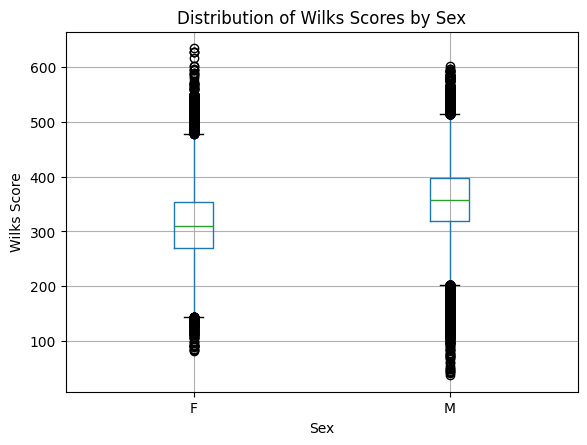

In [18]:
plt.figure()
df_clean.boxplot(
    column="Wilks",
    by="Sex",
    showfliers=True
)
plt.xlabel("Sex")
plt.ylabel("Wilks Score")
plt.title("Distribution of Wilks Scores by Sex")
plt.suptitle("")
plt.show()


#### Interpretation

The boxplot indicates that male lifters have a higher median Wilks score than female lifters, while both distributions show substantial overlap. The wide interquartile ranges and numerous outliers in each group indicate considerable variability in relative strength within both sexes

## 4. Research Questions

This analysis addresses the following questions:

1. Do Wilks scores differ significantly between male and female lifters?
2. Does total weight lifted differ across bodyweight classes?
3. Is bodyweight correlated with squat, bench press, and deadlift performance?
4. How does bodyweight relate to each lift under a linear regression model?


## 5. Assumption Checks

Assumptions are evaluated within each statistical analysis, as normality and variance requirements are model-specific rather than dataset-wide.


## 6.1 Wilks Scores by Sex (Welch’s t-Test)

Wilks scores were compared between male and female competitors using Welch’s independent-samples t-test. Welch’s test was selected due to its robustness to unequal variances in large samples.

**Hypotheses**
- H₀: Mean Wilks scores do not differ between male and female competitors.
- Hₐ: Mean Wilks scores differ between male and female competitors.


Normality was assessed separately by sex using Shapiro–Wilk tests on random subsamples and visual inspection of boxplots. Given the large sample size and absence of severe deviations, parametric testing was deemed appropriate.



In [23]:
# Male Wilks
male_sample = (
    df_clean[df_clean["Sex"] == "M"]["Wilks"]
    .dropna()
    .sample(n=5000, random_state=42)
)
W_m, p_m = shapiro(male_sample)

# Female Wilks
female_sample = (
    df_clean[df_clean["Sex"] == "F"]["Wilks"]
    .dropna()
    .sample(n=5000, random_state=42)
)
W_f, p_f = shapiro(female_sample)


normality_results = pd.DataFrame({
    "Group": ["Male", "Female"],
    "W_statistic": [W_m, W_f],
    "p_value": [p_m, p_f]
})

normality_results


,Group,W_statistic,p_value
0,Male,0.996083,2.860533e-10
1,Female,0.995871,1.176588e-10


 Formal tests indicated statistically detectable deviations from normality, which are expected in large samples. Visual diagnostics showed approximately symmetric distributions without severe skewness.

Given the large sample size and the robustness of Welch’s t-test to both non-normality and unequal variances, Welch’s t-test was used for inference.



### Welch’s Independent-Samples t-Test

Given the large sample size and Welch’s t-test’s robustness to non-normality and unequal variances, mean Wilks scores were compared between male and female competitors using Welch’s independent-samples t-test.


In [20]:
from scipy.stats import ttest_ind

male_wilks = df_clean[df_clean["Sex"] == "M"]["Wilks"].dropna()
female_wilks = df_clean[df_clean["Sex"] == "F"]["Wilks"].dropna()

# Welch's t-test
t_stat, p_val = ttest_ind(
    male_wilks,
    female_wilks,
    equal_var=False
)

pd.DataFrame({
    "Test": ["Welch t-test"],
    "t_statistic": [t_stat],
    "p_value": [p_val]
})


,Test,t_statistic,p_value
0,Welch t-test,168.221779,0.0


### Visualization

Boxplots show the distribution of Wilks scores by Sex as shown below.

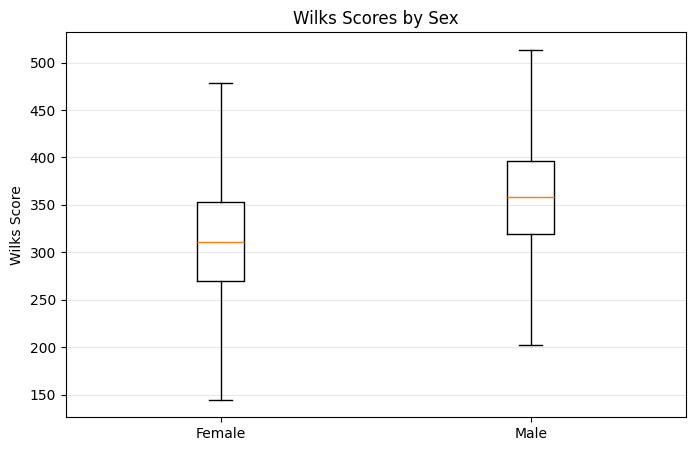

In [132]:
plt.figure(figsize=(8, 5))
plt.boxplot(
    [female_wilks, male_wilks],
    tick_labels=["Female", "Male"],
    showfliers=False
)

plt.ylabel("Wilks Score")
plt.title("Wilks Scores by Sex")
plt.grid(axis="y", alpha=0.3)
plt.show()

### Analysis

The Welch’s t-test produced a very large test statistic (t = 168.22) with a p-value effectively equal to zero, indicating a statistically significant difference in mean Wilks scores between male and female competitors. Practical significance is evaluated using descriptive statistics and effect size.

#### Effect Size and Descriptive Statistics

In [26]:
# Descriptive stats
n_m, n_f = len(male_wilks), len(female_wilks)
mean_m, mean_f = male_wilks.mean(), female_wilks.mean()
sd_m, sd_f = male_wilks.std(ddof=1), female_wilks.std(ddof=1)

mean_diff = mean_m - mean_f

# Cohen's d
pooled_sd = np.sqrt(((n_m - 1) * sd_m**2 + (n_f - 1) * sd_f**2) / (n_m + n_f - 2))
cohens_d = mean_diff / pooled_sd

summary = pd.DataFrame({
    "Group": ["Male", "Female"],
    "N": [n_m, n_f],
    "Mean Wilks": [mean_m, mean_f],
    "SD Wilks": [sd_m, sd_f],
})

summary


,Group,N,Mean Wilks,SD Wilks
0,Male,164275,357.198186,60.783552
1,Female,83834,312.899118,62.674730


Male competitors had higher mean Wilks scores (M = 357.2, SD = 60.8) than female competitors (M = 312.9, SD = 62.7). This difference was statistically significant, with a mean difference of 44.3 Wilks points and a moderate-to-large effect size (Cohen’s d = 0.72), indicating practical significance.


## 6.2 Total Weight Lifted by Weight Class (Welch’s ANOVA)

Differences in mean total weight lifted (TotalKg) across competition weight classes were evaluated using Welch’s one-way ANOVA. Welch’s ANOVA was selected due to its robustness to unequal variances across groups.

To ensure adequate representation, analysis was restricted to commonly represented weight classes (57, 63, 74, 83, 93, 105, 110, and 120+), each with at least 5,000 competitors and spanning the full bodyweight range.

**Hypotheses**
- H₀: Mean total weight lifted does not differ across weight classes.
- Hₐ: At least one weight class has a different mean total weight lifted.

In this analysis, normality of total weight lifted (TotalKg) is evaluated within the selected weight classes representing the broad range of bodyweights seen in competition.


In [33]:
selected_classes = ["57", "63", "74", "83", "93", "105", "110", "120+"]

df_anova = df_clean.loc[
    df_clean["WeightClassKg"].isin(selected_classes),
    ["WeightClassKg", "TotalKg"]
].dropna()

N = 3000
rng = 42

rows = []

for wc in selected_classes:
    s = df_anova.loc[df_anova["WeightClassKg"] == wc, "TotalKg"]
    sample = s.sample(n=min(N, len(s)), random_state=rng)

    W, p = shapiro(sample)

    rows.append({
        "WeightClassKg": f"{wc}kg",
        "W_statistic": round(W, 3),
        "p_value": p
    })

normality_df = pd.DataFrame(rows)
normality_df


,WeightClassKg,W_statistic,p_value
0,57kg,0.996,4.171444e-07
1,63kg,0.999,1.114310e-02
2,74kg,0.996,1.452632e-06
3,83kg,0.998,2.320908e-04
4,93kg,0.996,1.237271e-07
5,105kg,0.993,5.981490e-11
6,110kg,0.995,6.191122e-08
7,120+kg,0.997,6.196658e-05


Although the Shapiro–Wilk test rejected perfect normality (W > 0.993, p < 0.012 for all weight classes), given the large sample size (n > 5000) the central limit theorem ensures that parametric tests remain robust.

---


### Welch’s ANOVA

Given the large sample size, minor departures from normality, and the robustness of Welch’s ANOVA test to unequal variances, Welch’s ANOVA was used to compare mean Wilks scores across weight classes.



In [126]:
selected_classes = ["57", "63", "74", "83", "93", "105", "110", "120+"]


# Extract TotalKg values as a group
groups = [
    df_anova.loc[df_anova["WeightClassKg"] == wc, "TotalKg"].dropna().to_numpy()
    for wc in selected_classes
]

welch = sm_ow.anova_oneway(groups, use_var="unequal")  # Welch one-way ANOVA

print("Welch’s One-Way ANOVA: TotalKg by Weight Class")
print(f"F statistic: {welch.statistic:.3f}")
print(f"p-value:     {welch.pvalue:.3e}")
print(f"df (between): {welch.df_num:.0f}")
print(f"df (within):  {welch.df_denom:.2f}")

group_summary = (
    df_anova[df_anova["WeightClassKg"].isin(selected_classes)]
    .groupby("WeightClassKg")["TotalKg"]
    .agg(N="count", Mean="mean", SD="std")
    .reindex(selected_classes)
)

print("Group Summary: Total Weight Lifted by Weight Class\n")
for wc, row in group_summary.iterrows():
    print(
        f"Weight class {wc:>4}kg: "
        f"N = {int(row['N']):5d}, "
        f"Mean = {row['Mean']:6.2f} kg, "
        f"SD = {row['SD']:6.2f} kg"
    )


Welch’s One-Way ANOVA: TotalKg by Weight Class
F statistic: 41407.304
p-value:     0.000e+00
df (between): 7
df (within):  35815.07
Group Summary: Total Weight Lifted by Weight Class

Weight class   57kg: N =  7639, Mean = 281.90 kg, SD =  52.20 kg
Weight class   63kg: N = 11799, Mean = 296.08 kg, SD =  56.26 kg
Weight class   74kg: N = 14911, Mean = 486.75 kg, SD =  83.67 kg
Weight class   83kg: N = 22133, Mean = 522.21 kg, SD =  86.95 kg
Weight class   93kg: N = 24081, Mean = 555.94 kg, SD =  91.29 kg
Weight class  105kg: N = 18588, Mean = 588.95 kg, SD =  96.43 kg
Weight class  110kg: N =  7325, Mean = 612.16 kg, SD = 107.97 kg
Weight class 120+kg: N =  5971, Mean = 663.94 kg, SD = 127.98 kg


#### Visualization

Boxplots showing the distribution of total weight lifted by weight class is show below.

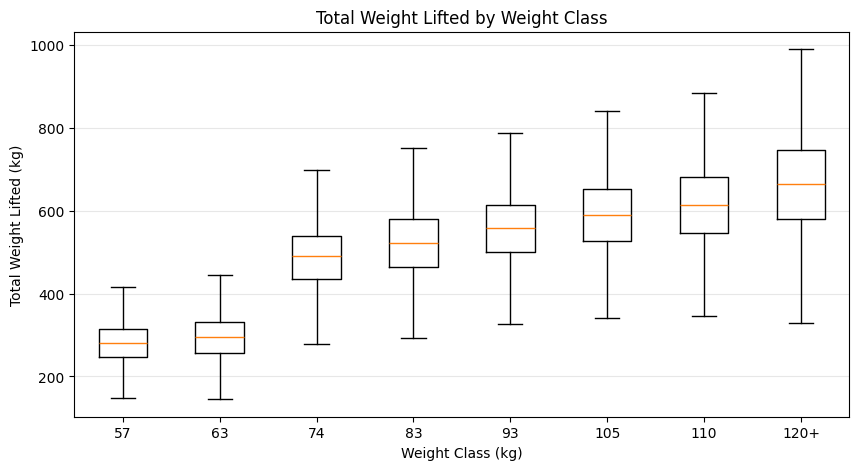

In [134]:
weight_classes = ["57", "63", "74", "83", "93", "105", "110", "120+"]

anova_data = [
    df_clean[df_clean["WeightClassKg"] == wc]["TotalKg"]
    for wc in weight_classes
]

plt.figure(figsize=(10, 5))
plt.boxplot(anova_data, tick_labels=weight_classes, showfliers=False)

plt.xlabel("Weight Class (kg)")
plt.ylabel("Total Weight Lifted (kg)")
plt.title("Total Weight Lifted by Weight Class")
plt.grid(axis="y", alpha=0.3)
plt.show()


### Turkey HSD

After a significant ANOVA result, Tukey’s HSD (Honestly Significant Difference) is used to identify **which specific group means differ**, while controlling the **family-wise error rate** across all pairwise comparisons. Here, Tukey HSD compares mean TotalKg between weight classes to pinpoint where the differences occur.

In [37]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

anova_df = df_clean[df_clean["WeightClassKg"].isin(
    ["57", "63", "74", "83", "93", "105", "110","120+"]
)]

tukey = pairwise_tukeyhsd(
    endog=anova_df["TotalKg"],
    groups=anova_df["WeightClassKg"],
    alpha=0.05
)

tukey_df = pd.DataFrame(
    data=tukey.summary().data[1:],  # rows excluding header
    columns=tukey.summary().data[0] # header
)

tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,105,110,23.2115,0.0,19.4987,26.9243,True
1,105,120+,74.9951,0.0,70.9917,78.9985,True
2,105,57,-307.0541,0.0,-310.7118,-303.3964,True
3,105,63,-292.8719,0.0,-296.0398,-289.7040,True
4,105,74,-102.1970,0.0,-105.1558,-99.2383,True
5,105,83,-66.7367,0.0,-69.4143,-64.0592,True
6,105,93,-33.0142,0.0,-35.6418,-30.3865,True
7,110,120+,51.7837,0.0,47.0912,56.4761,True
8,110,57,-330.2656,0.0,-334.6667,-325.8644,True
9,110,63,-316.0834,0.0,-320.0867,-312.0800,True


### Analysis

Welch’s one-way ANOVA indicated a significant difference in mean total weight lifted across weight classes (F(7, 35,815.07) = 41,407.30, p < 0.001)). Mean total weight lifted increased monotonically with weight class, with heavier classes lifting substantially more weight on average and exhibiting greater variability.

Post-hoc Tukey HSD tests showed that all pairwise comparisons between weight classes were statistically significant at α = 0.05, confirming that differences in total weight lifted across classes are systematic rather than incidental.



## 6.3 Correlation Analysis: Bodyweight and Competition Lifts

Pearson correlation was used to quantify the linear association between competitor bodyweight (BodyweightKg) and performance in the three competition lifts: squat, bench press, and deadlift. All variables are continuous, competitor performances are independent, and the objective is to measure the strength and direction of linear relationships.

**Hypotheses (for each lift)**
- H₀: There is no linear correlation between bodyweight and performance in the lift.
- Hₐ: There is a linear correlation between bodyweight and performance in the lift.

Scatterplots of bodyweight against each lift showed clear positive linear trends without severe outliers, supporting the use of Pearson correlation. Correlation coefficients were computed separately for squat, bench press, and deadlift to compare the strength of association across lifts.


In [146]:
import pandas as pd

# Create regression results table
results_reg = pd.DataFrame({
    "Lift": [
        "Squat",
        "Bench Press",
        "Deadlift"
    ],
    "Slope (β₁)": [
        1.786,
        1.348,
        1.717
    ],
    "Intercept (β₀)": [
        14.66,
        -4.79,
        50.12
    ],
    "R²": [
        0.430,
        0.436,
        0.386
    ],
    "p-Value (β₁)": [
        "< 0.001",
        "< 0.001",
        "< 0.001"
    ]
})

# Start index at 1
results_reg.index = range(1, len(results_reg) + 1)
results_reg.index.name = "Result #"

results_reg


,Lift,Slope (β₁),Intercept (β₀),R²,p-Value (β₁)
Result #,,,,,
1,Squat,1.786,14.66,0.430,< 0.001
2,Bench Press,1.348,-4.79,0.436,< 0.001
3,Deadlift,1.717,50.12,0.386,< 0.001


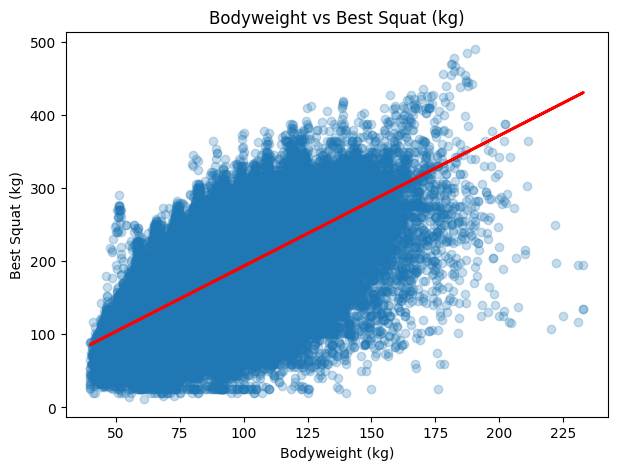

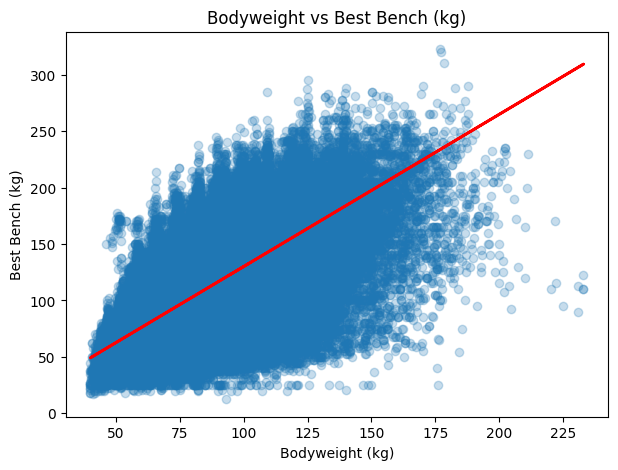

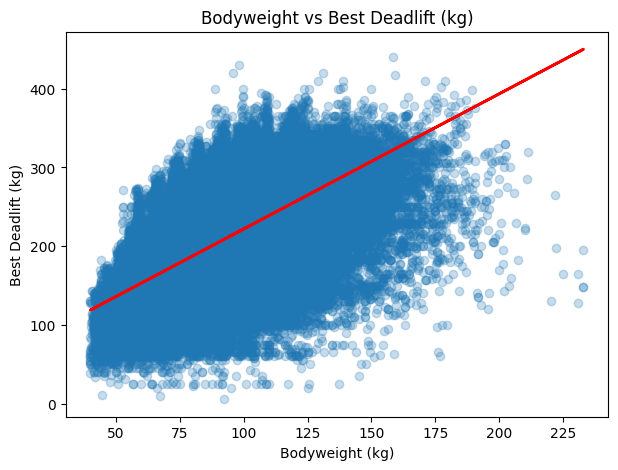

In [40]:
pairs = [
    ("Best3SquatKg", "Best Squat (kg)"),
    ("Best3BenchKg", "Best Bench (kg)"),
    ("Best3DeadliftKg", "Best Deadlift (kg)")
]

for col, y_label in pairs:
    plot_df = df_clean[["BodyweightKg", col]].dropna()

    x = plot_df["BodyweightKg"]
    y = plot_df[col]

    plt.figure(figsize=(7, 5))
    plt.scatter(x, y, alpha=0.25)

    # simple linear fit for visual guidance only
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m * x + b, color = "red", linewidth = 2)

    plt.xlabel("Bodyweight (kg)")
    plt.ylabel(y_label)
    plt.title(f"Bodyweight vs {y_label}")
    plt.show()


#### Interpretation

Scatterplots show clear positive linear relationships between bodyweight and performance across all three competition lifts, with greater variability at higher bodyweights but no severe departures from linearity. Pearson correlation was therefore used to quantify the strength and direction of these associations.


In [100]:
from scipy.stats import pearsonr

results = []

for lift in ["Best3SquatKg", "Best3BenchKg", "Best3DeadliftKg"]:
    data = df_clean[["BodyweightKg", lift]].dropna()
    r, p = pearsonr(data["BodyweightKg"], data[lift])
    results.append((lift, r, p))

corr_df = pd.DataFrame(
    results,
    columns=["Lift", "Pearson_r", "Pearson_p"]
)

corr_df


,Lift,Pearson_r,Pearson_p
0,Best3SquatKg,0.655767,0.0
1,Best3BenchKg,0.660249,0.0
2,Best3DeadliftKg,0.621069,0.0


Pearson correlation analysis showed strong positive associations between bodyweight and performance across all three competition lifts. Bodyweight was moderately to strongly correlated with squat (r = 0.656), bench press (r = 0.660), and deadlift (r = 0.621), with all correlations statistically significant (p < 0.001).

Correlation strength varied slightly by lift, with squat and bench press showing marginally stronger associations with bodyweight than deadlift, indicating that increases in bodyweight are most strongly linked to improvements in squat and upper-body performance.


## 6.4 Regression Analysis: Predicting Lift Performance from Bodyweight

Simple linear regression was used to model lift performance as a function of bodyweight, estimating the average change in squat, bench press, and deadlift performance associated with a one-kilogram increase in bodyweight. Separate models were fit for each lift to compare the strength of this relationship across movements.


In [112]:
import statsmodels.api as sm

lifts = [
    ("Best3SquatKg", "Squat"),
    ("Best3BenchKg", "Bench Press"),
    ("Best3DeadliftKg", "Deadlift")
]

reg_results = []

for y_col, lift_name in lifts:
    data = df_clean[["BodyweightKg", y_col]].dropna()

    X = sm.add_constant(data["BodyweightKg"])   # adds intercept
    y = data[y_col]

    model = sm.OLS(y, X).fit()

    reg_results.append({
        "Lift": lift_name,
        "N": int(model.nobs),
        "β₁ (kg per kg BW)": model.params["BodyweightKg"],
        "β₀": model.params["const"],
        "R²": model.rsquared,
        "p-value (β₁)": model.pvalues["BodyweightKg"]
    })

reg_df = pd.DataFrame(reg_results)
reg_df


,Lift,N,β₁ (kg per kg BW),β₀,R²,p-value (β₁)
0,Squat,248109,1.785974,14.662402,0.430030,0.0
1,Bench Press,248109,1.347963,-4.793923,0.435929,0.0
2,Deadlift,248109,1.716543,50.116106,0.385726,0.0


### Visualization

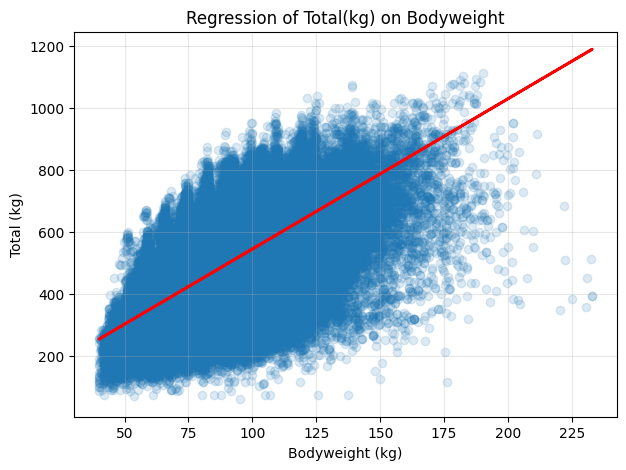

In [141]:
import numpy as np

x = df_clean["BodyweightKg"]
y = df_clean["TotalKg"]
m, b = np.polyfit(x, y, 1)

plt.figure(figsize=(7, 5))
plt.scatter(x, y, alpha=0.15)
plt.plot(x, m * x + b, color="red", linewidth=2)

plt.xlabel("Bodyweight (kg)")
plt.ylabel("Total (kg)")
plt.title("Regression of Total(kg) on Bodyweight")
plt.grid(alpha=0.3)
plt.show()


#### Regression Results

Bodyweight was a statistically significant predictor of performance across all three lifts (p < 0.001). Estimated slopes indicate that lift performance increases with bodyweight, with the magnitude of this effect varying slightly by lift. Model fit was moderate (R² ≈ 0.39–0.44), indicating that bodyweight explains a substantial portion of performance variation.

Regression slopes indicate that lift performance increases by approximately 1.8 kg per kg bodyweight for squat, 1.3 kg per kg for bench press, and 1.7 kg per kg for deadlift. These estimates suggest that squat and deadlift performance are more sensitive to changes in bodyweight than bench press, while all three lifts show a meaningful positive relationship.





## Summary and Conclusions

Analysis of competitive powerlifting data shows that bodyweight is strongly related to performance across multiple dimensions. Wilks scores differed meaningfully by sex, with male competitors exhibiting higher relative strength on average. Total weight lifted increased systematically across competition weight classes, supporting the validity of weight class structure in organizing absolute strength performance.

Across individual lifts, bodyweight was moderately to strongly associated with squat, bench press, and deadlift performance. Linear regression results indicate that performance increases by approximately 1.8 kg per kg bodyweight for squat, 1.3 kg for bench press, and 1.7 kg for deadlift, suggesting that squat and deadlift performance are more sensitive to changes in bodyweight than bench press. While bodyweight explains a substantial portion of performance variability.

Taken together, these results illustrate how group comparisons, correlation, and regression provide complementary perspectives on strength performance, and highlight bodyweight as a important factor for powerlifters  and coaches to consider.
